# Summary
This code is written to learn the time step for the ML model written in `MLmodel8.ipynb`.

In the first attempt I want to make dt to be only a function of velocity and not $\theta$. If it does not work, I will write it to be a function of $\theta$ as well.


# Importing

In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from ProcessFunctions import find_Aisv2,Find_a_i,find_Aisv2_onlyv
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.interpolate import interp1d
import seaborn as sns 

In [19]:
# Loading POD modes
data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/MainSimulation_Tf600Nt=5PODonlyonV.npz"
PODmodes=np.load(data_dir)
U_v=PODmodes['U']
S_v=PODmodes['S']
VT_v=PODmodes['VT']
q_bar_v=PODmodes['q_bar']

data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/MainSimulation_Tf600Nt=5PODonlyontheta.npz"
PODmodes=np.load(data_dir)
U_theta=PODmodes['U']
S_theta=PODmodes['S']
VT_theta=PODmodes['VT']
q_bar_theta=PODmodes['q_bar']

In [ ]:
# Loading data from "/central/groups/astuart/hkaveh/Data/LearnROM/"
Tf = 250 # each initial condition is simulated for 250 years
Nt=5     # it is recorded every Nt time stes
N_m_v=20 # number of modes that they have considered
# N_m_theta=25 # number of modes that they have considered
coeff=2 # How the inital conditions are from the chaotic attractor
number=10 # Which one do you want to load
N_cut=2000
# loading time series:
N_m_load=30

X_full=np.empty((1,N_m_load))
Y_full=np.empty((1,1))
V_max_QDYN=np.empty((1,1))
phi_v=U_v[:,:N_m_load]    # This contains the eigen mode for velocity

for number in range(100):
    data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/Dataset2/SampleSimulation_Tf"+str(Tf)+"Nt="+str(Nt)+"N_m"+str(N_m_load)+"coeff"+str(coeff)+"number"+str(number)+".npz"
    data_smaple=np.load(data_dir)
    V_ox=data_smaple['array1']
    theta_ox=data_smaple['array2']
    t_ox=data_smaple['array3']

    # We work we log10 of V_ox:
    V_ox=np.log10(V_ox)
    V_max_onesimulation=np.max(V_ox,axis=(1,2))
    theta_ox=np.log10(theta_ox)
    # adding one dimension to t=t_ox[:,0,0] numpy
    t=t_ox[:,0,0].reshape(-1,1)
    dt=t[1:]-t[:-1]
    dt=np.log10(dt)



    A_v,P_v=find_Aisv2_onlyv(U_v,V_ox,q_bar_v,N_m_load) # you dont need P in general, but I need it to check if I do everything correctly
    A_theta,P_theta=find_Aisv2_onlyv(U_theta,theta_ox,q_bar_theta,N_m_load)
    # concatenating the two arrays
    #A=np.concatenate((A_v,A_theta),axis=1)
    A=A_v
    X_onesimulation=A[:-1,:]
    Y_onesimulation=dt
    X_full=np.append(X_full,X_onesimulation,axis=0)
    Y_full=np.append(Y_full,Y_onesimulation,axis=0)
    V_max_QDYN=np.append(V_max_QDYN,V_max_onesimulation[:-1])
    print("number is " +str(number)+ " size of data in this simulation is " +str(X_onesimulation.shape[0])+" total size is " + str(X_full.shape[0]))

# removing the first row which is empty
X_full=X_full[1:,:]
Y_full=Y_full[1:,:]
V_max_QDYN=V_max_QDYN[1:]
print(np.max(X_full))
print(np.max(Y_full))
max_X_full=np.max(X_full)
max_Y_full=np.max(Y_full)


# deleting some colomns from X_full and Y_full that are should not be included based on N_m_v and N_m_theta
# index of the columns that should be deleted
index_delete=np.array([])
if N_m_v<N_m_load:
    index_delete=np.append(index_delete,np.arange(N_m_v,N_m_load))
# if N_m_theta<N_m_load:
#     index_delete=np.append(index_delete,np.arange(N_m_load+N_m_theta,2*N_m_load))


# Convert the array elements to integers
index_delete = index_delete.astype(int)
phi_v=np.delete(phi_v,index_delete,axis=1)
X_full=np.delete(X_full,index_delete,axis=1)
print("index of the columns that are deleted are:")
print(index_delete)

print(X_full.shape)
print("size of the data is " +str(X_full.shape[0]))
print("shape phi_v is "+str(phi_v.shape))

number is 0 size of data in this simulation is 8500 total size is 8501
124.30425029565085
7.251675241367818
index of the columns that are deleted are:
[20 21 22 23 24 25 26 27 28 29]
(8500, 20)
size of the data is 8500
shape phi_v is (8192, 20)


# Plot the relationship between Vmax and dt

In [21]:
def find_logvmax(alpha,phi_v):
    v=np.dot(phi_v,alpha)[:, np.newaxis]+q_bar_v # v and theta
    logvmax=np.max(v)
    return logvmax

In [22]:
logvmax_reducedmodel=np.zeros((X_full.shape[0],1))
logmax_model=np.zeros((X_full.shape[0],1))
for i in range(X_full.shape[0]):
    logvmax_reducedmodel[i,0]=find_logvmax(X_full[i,:N_m_v],phi_v)

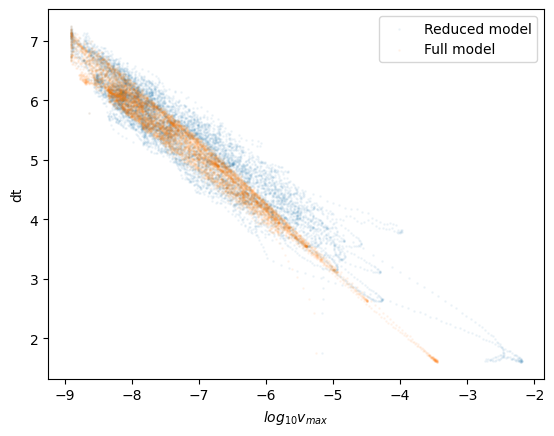

In [23]:
plt.scatter(logvmax_reducedmodel,Y_full,label='Reduced model',s=1,alpha=0.05)
plt.scatter(V_max_QDYN,Y_full,label='Full model',s=1,alpha=0.05)
plt.xlabel(r'$log_{10}v_{max}$')
plt.ylabel(r'dt')
plt.legend()
# saving the figure in fig directory
# plt.savefig('Figs/LogVmax_dt.png',dpi=400)


# ML model

In [8]:
X_full=X_full/max_X_full
Y_full=Y_full/max_Y_full
X_full = np.concatenate((X_full, logvmax_reducedmodel), axis=1)
print(max_X_full)
print(max_Y_full)


656.2927824752376
7.41121236410035


In [9]:
X_cut=X_full[-N_cut:,:]
Y_cut=Y_full[-N_cut:,:]
X=X_full[1:-N_cut,:] # Also, removing the first element
Y=Y_full[1:-N_cut,:] 



In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)
# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(4940, 21)
(4940, 1)
(1236, 21)
(1236, 1)


In [ ]:
# %% Defining model
class Forwardmap(nn.Module):
    def __init__(self,N_m_v):
        super().__init__()
        self.hidden1=nn.Linear(N_m_v+1,2*N_m_v)
        self.act1=nn.Tanh()
        self.hidden2=nn.Linear(2*N_m_v,4*N_m_v)
        self.act2=nn.Tanh()
        self.hidden3=nn.Linear(4*N_m_v,4*N_m_v)
        self.act3=nn.Tanh()
        self.hidden4=nn.Linear(4*N_m_v,2*N_m_v)
        self.act4=nn.Tanh()
        self.output=nn.Linear(2*N_m_v,1)

    def forward(self,x):
        x=self.act1(self.hidden1(x))
        x=self.act2(self.hidden2(x))
        x=self.act3(self.hidden3(x))
        x=self.act4(self.hidden4(x))
        x=(self.output(x))
        return x

model=Forwardmap(N_m_v)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

print(model)
loss_fn=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
# Define the scheduler for changing learning rate every 20 epochs
lr_decay_factor = 0.5
lr_scheduler_step = 50
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step, gamma=lr_decay_factor)

Forwardmap(
  (hidden1): Linear(in_features=21, out_features=40, bias=True)
  (act1): Tanh()
  (hidden2): Linear(in_features=40, out_features=80, bias=True)
  (act2): Tanh()
  (hidden3): Linear(in_features=80, out_features=80, bias=True)
  (act3): Tanh()
  (hidden4): Linear(in_features=80, out_features=40, bias=True)
  (act4): Tanh()
  (output): Linear(in_features=40, out_features=1, bias=True)
)


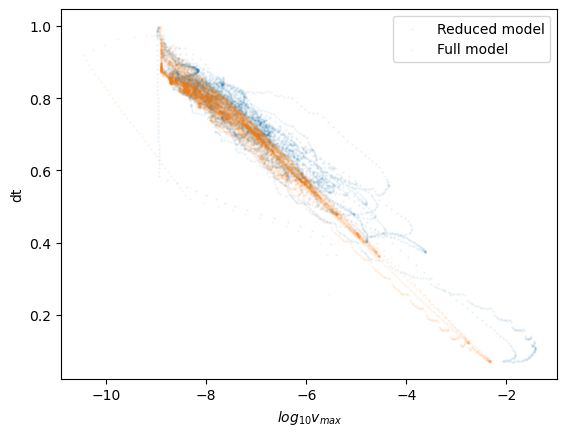

In [12]:
plt.scatter(X[:,-1],Y,label='Reduced model',s=1,alpha=0.05)
plt.scatter(V_max_QDYN,Y_full,label='Full model',s=1,alpha=0.05)
plt.xlabel(r'$log_{10}v_{max}$')
plt.ylabel(r'dt')
plt.legend()
# saving the figure in fig directory
#plt.savefig('Figs/LogVmax_dt.png',dpi=400)


In [ ]:
num_epochs=150
for epoch in range(num_epochs):
    model.train()
    for inputs,targets in train_dataloader:
        # Move inputs and targets to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=loss_fn(outputs,targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(current_lr)

Epoch [1/100], Loss: 0.003527
0.001
Epoch [2/100], Loss: 0.001672
0.001
Epoch [3/100], Loss: 0.004023
0.001
Epoch [4/100], Loss: 0.001927
0.001
Epoch [5/100], Loss: 0.001042
0.001
Epoch [6/100], Loss: 0.002266
0.001
Epoch [7/100], Loss: 0.001295
0.001
Epoch [8/100], Loss: 0.001965
0.001
Epoch [9/100], Loss: 0.001231
0.001
Epoch [10/100], Loss: 0.000900
0.001
Epoch [11/100], Loss: 0.000627
0.001
Epoch [12/100], Loss: 0.000792
0.001
Epoch [13/100], Loss: 0.002972
0.001
Epoch [14/100], Loss: 0.001029
0.001
Epoch [15/100], Loss: 0.000596
0.001
Epoch [16/100], Loss: 0.000770
0.001
Epoch [17/100], Loss: 0.000510
0.001
Epoch [18/100], Loss: 0.000774
0.001
Epoch [19/100], Loss: 0.000573
0.001
Epoch [20/100], Loss: 0.000960
0.001
Epoch [21/100], Loss: 0.000657
0.001
Epoch [22/100], Loss: 0.000199
0.001
Epoch [23/100], Loss: 0.001028
0.001
Epoch [24/100], Loss: 0.001438
0.001
Epoch [25/100], Loss: 0.000672
0.001
Epoch [26/100], Loss: 0.000652
0.001
Epoch [27/100], Loss: 0.000914
0.001
Epoch [28/

In [ ]:
# Evaluate the model on the test set
model.eval()
device = torch.device( "cpu")
print(device)
model.to(device)

total_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        total_loss += loss.item() * inputs.size(0)

mean_loss = total_loss / len(test_dataset)
print(f'Test Loss: {mean_loss:.4f}')

Test Loss: 0.0003


In [15]:
# save the model in the group directory
version=2024.11
torch.save(model.state_dict(), "/central/groups/astuart/hkaveh/Data/LearnROM/ROMdt_POD_separate_onV_theta"+str(version)+"N_m_v"+str(N_m_v)+".pt")

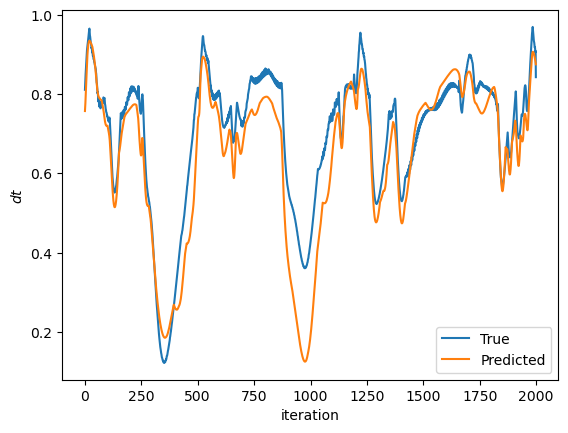

In [16]:
X_cut_tensor = torch.tensor(X_cut, dtype=torch.float32)
index=np.linspace(1,N_cut-1,N_cut-1)
Pred=model(X_cut_tensor)
plt.plot(Y_cut[:,0],label='True')
plt.plot(Pred.detach().numpy()[:,0],label='Predicted')
plt.xlabel('iteration')
plt.ylabel(r'$dt$')
plt.legend()
#plt.savefig('./Figs/Performancedt.png')

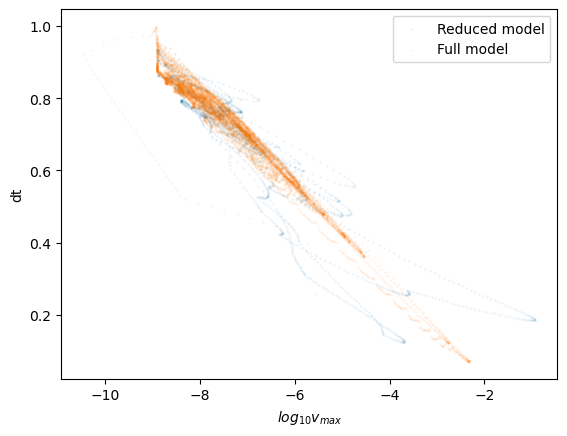

In [17]:
plt.scatter(X_cut[:,-1],Pred.detach().numpy()[:,0],label='Reduced model',s=1,alpha=0.05)
plt.scatter(V_max_QDYN,Y_full,label='Full model',s=1,alpha=0.05)
plt.xlabel(r'$log_{10}v_{max}$')
plt.ylabel(r'dt')
plt.legend()
# saving the figure in fig directory
#plt.savefig('Figs/LogVmax_dt.png',dpi=400)